In [56]:
import numpy as np
import math

def get_intersections(x0, y0, r0, x1, y1, r1, n=10):#find intersection points of two circles
    # circle 1: (x0, y0), radius r0
    # circle 2: (x1, y1), radius r1

    d=math.sqrt((x1-x0)**2 + (y1-y0)**2)
    
    #change the following nones to be more descriptive
    
    # non intersecting
    if d > r0 + r1 :
        return 'non intersecting'
    # One circle within other
    if d < abs(r0-r1):
        return 'inscribed'
    # coincident circles
    if d == 0 and r0 == r1:
        points=[]
        for i in range(math.ceil(n*0.01)):
            points.append(x0+r0*np.cos(i*2*math.pi*(1/math.ceil(n*0.01))),y0+r0*np.sin(i*2*math.pi*(1/math.ceil(n*0.01))))
        return points
    else:
        a=(r0**2-r1**2+d**2)/(2*d)
        h=math.sqrt(r0**2-a**2)
        x2=x0+a*(x1-x0)/d   
        y2=y0+a*(y1-y0)/d   
        x3=x2+h*(y1-y0)/d     
        y3=y2-h*(x1-x0)/d 

        x4=x2-h*(y1-y0)/d
        y4=y2+h*(x1-x0)/d
        
        return [[x3, y3], [x4, y4]]
    
def pentagon(z3, dist): #z3 in numpy array form
    if np.linalg.norm(z3-np.array([1,0]))>dist[0]+dist[1] or np.linalg.norm(z3)>dist[2]+dist[3]:
        print(z3)
        raise Exception('z3 out of range')
    
    z2s=get_intersections(z3[0], z3[1], dist[1], 1, 0, dist[0])
    z4s=get_intersections(z3[0], z3[1], dist[2], 0, 0, dist[3])
    
    output=[]
    for i in z2s:
        for j in z4s:
            if type(j)==str or type(i)==str:
                continue
            output.append([[1,0],i,z3,j,[0,0]])
            output.append([[1,0],[i[0],-1*i[1]],[z3[0],-1*z3[1]],[j[0],-1*j[1]],[1,0]])
    return np.asarray(output,dtype=object)

#def check_validity(pent, dist):
    
    
def moduli_space_sample(n, dist):
    x_vals=np.linspace(1-(dist[0]+dist[1]),dist[2]+dist[3],math.ceil(math.sqrt(n//2)))
    ymax=max(get_intersections(0,0,dist[2]+dist[3],1,0,dist[0]+dist[1])[0][1],get_intersections(0,0,dist[2]+dist[3],1,0,dist[0]+dist[1])[1][1])
    ymin=min(get_intersections(0,0,dist[2]+dist[3],1,0,dist[0]+dist[1])[0][1],get_intersections(0,0,dist[2]+dist[3],1,0,dist[0]+dist[1])[1][1])
    y_vals=np.linspace(ymin,ymax,math.ceil(math.sqrt(n//2)))
    coords=[np.array([x,y]) for x in x_vals for y in y_vals]
    
    output=[]
    for i in coords:
        if np.linalg.norm(i-np.array([1,0]))<=dist[0]+dist[1] and np.linalg.norm(i)<=dist[2]+dist[3]:
            for pent in pentagon(i,dist):
                output.append(pent)
    return np.asarray(output,dtype=object)
    
    

In [19]:
p=pentagon(np.array([1,1]),[1,1,1,1])
p[0]

array([[1, 0],
       [0.1339745962155614, 0.5],
       [1, 1],
       [5.551115123125783e-17, 0.9999999999999998],
       [0, 0]], dtype=object)

[[1 0]
 [0.1339745962155614 0.5]
 [1 1]
 [5.551115123125783e-17 0.9999999999999998]
 [0 0]]


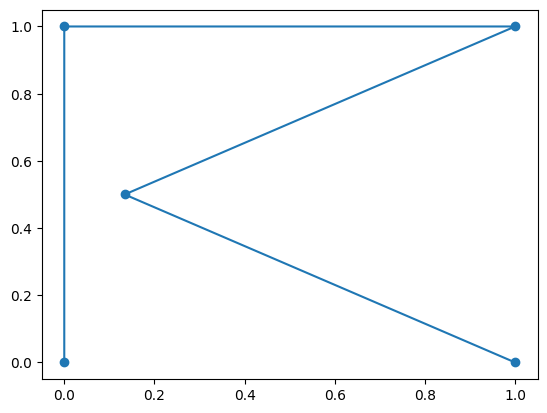

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
data=p[0]
#plt.rcParams["figure.figsize"] = [4.0, 3.50]
plt.scatter(data[:,0],data[:,1])
plt.plot(data[:,0],data[:,1])
print(data)
plt.show()

In [55]:
a=moduli_space_sample(14000, [0.05,0.05,0.1,1])#[0.6,0.6,0.6,1]
len(a)

55776

In [51]:
from xlwt import Workbook
wb0 = Workbook()
sheet2 = wb0.add_sheet('Sheet 1')

def clean(i):
    return (str(np.array(i[0]).tolist())+', '+str(np.array(i[1]).tolist())).replace('[','').replace(']','')

for count1, pent in enumerate(a):
    for count2, i in enumerate(pent):
        sheet2.write(count1, count2, clean(i))

wb0.save('spinning top.xls')